In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import glob
import math
import progressbar

In [ ]:
!python --version

Python 3.10.11


In [ ]:
# Image Visualization

def plot_images(images, num_images=3, cmap='virdis'):
    # Select random images
    indices = np.random.choice(images.shape[0], num_images, replace=False)
    selected_images = images[indices]
    
    # Plot as 3-channel images
    fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(20, 4))
    for i in range(num_images):
        axes[0,i].imshow(selected_images[i], cmap=cmap)
        axes[0,i].axis('off')
        if i == 0:
            axes[0,i].set_title('3-Channel Image')
    
    # Plot as single-channel images
    single_channel_images = selected_images[:, :, :, 0]
    for i in range(num_images):
        axes[1,i].imshow(single_channel_images[i], cmap=cmap)
        axes[1,i].axis('off')
        if i == 0:
            axes[1,i].set_title('Single-Channel Image')
    
    plt.show()

In [ ]:
# Calculating PSNR

def psnr(original_image, reconstructed_image):
    mse = torch.mean((original_image - reconstructed_image) ** 2)
    max_pixel = torch.max(original_image)
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr.item()

In [ ]:
# Define the dual autoencoder model
class DualAutoencoder(nn.Module):
  def __init__(self, encoder, decoder):
    super(DualAutoencoder, self).__init__()

    self.encoder = encoder
        
    self.intermediate = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(0.1),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(0.1),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(0.1),
        nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1))

    self.decoder = decoder
    

  def forward(self, x):
      x = self.encoder(x)
      x = self.intermediate(x)
      x = self.decoder(x)
      return x
    


In [ ]:
### LOADING LOW RES DATA

# Directory containing the npz files
low_dir_path = '/content/drive/MyDrive/Colab Notebooks/data/low2'

# Search for all npz files in the directory
low_npz_files = glob.glob(f'{low_dir_path}/*.npz')
low_npz_files.sort()

# Load images from all npz files
low_images_list = []
for npz_file in progressbar.progressbar(low_npz_files):
  low_dataset = np.load(npz_file)
  low_images = low_dataset['image_data']

  # Normalize each channel between 0 and 1
  low_images_norm = np.zeros_like(low_images)
  for i in range(3):
    low_images_norm[:, :, :, i] = (low_images[:, :, :, i] - low_images[:, :, :, i].min()) / (low_images[:, :, :, i].max() - low_images[:, :, :, i].min())

  low_images_list.append(low_images_norm)

# Concatenate images from all npz files into a single numpy array
low_images = np.concatenate(low_images_list, axis=0)



100% (125 of 125) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


In [ ]:
### LOADING HIGH RES DATA

# Directory containing the npz files
high_dir_path = '/content/drive/MyDrive/Colab Notebooks/data/high2'

# Search for all npz files in the directory
high_npz_files = glob.glob(f'{high_dir_path}/*.npz')
high_npz_files.sort()

# Load images from all npz files
high_images_list = []
for npz_file in progressbar.progressbar(high_npz_files):
  high_dataset = np.load(npz_file)
  high_images = high_dataset['image_data']

  # Normalize each channel between 0 and 1
  high_images_norm = np.zeros_like(high_images)
  for i in range(3):
    high_images_norm[:, :, :, i] = (high_images[:, :, :, i] - high_images[:, :, :, i].min()) / (high_images[:, :, :, i].max() - high_images[:, :, :, i].min())

  high_images_list.append(high_images_norm)

# Concatenate images from all npz files into a single numpy array
high_images = np.concatenate(high_images_list, axis=0)

100% (125 of 125) |######################| Elapsed Time: 0:00:12 Time:  0:00:12


Displaying sample images from dataset

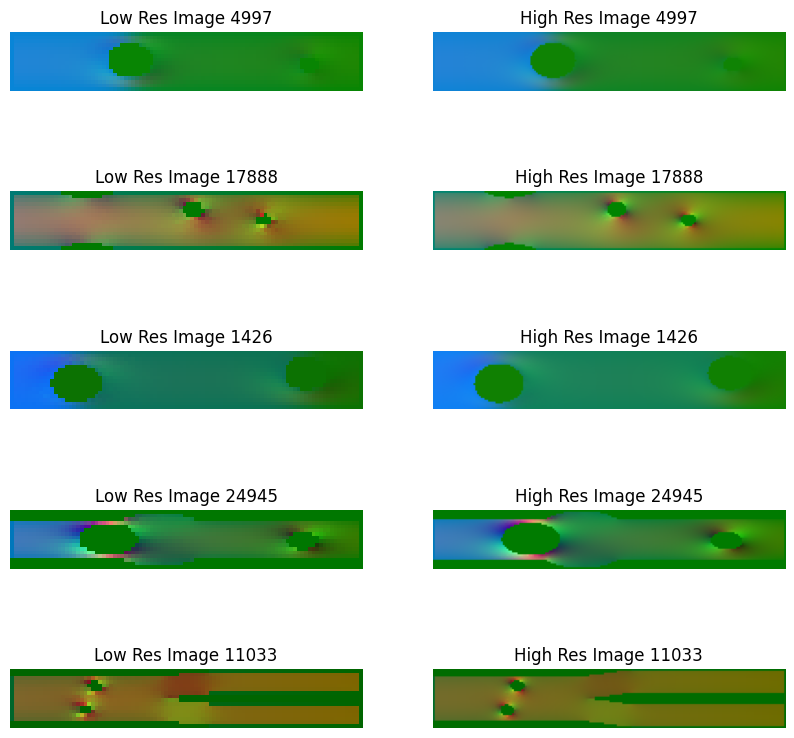

In [ ]:
import random
import matplotlib.pyplot as plt

# Set the number of pairs to display
n_pairs = 5

# Select n_pairs random indices from the images arrays
indices = random.sample(range(low_images.shape[0]), n_pairs)

# Plot each pair of images
fig, ax = plt.subplots(n_pairs, 2, figsize=(10, 10))

for i, idx in enumerate(indices):
    # Plot low resolution image
    ax[i, 0].imshow(low_images[idx])
    ax[i, 0].set_title(f'Low Res Image {idx}')
    ax[i, 0].axis('off')
    
    # Plot high resolution image
    ax[i, 1].imshow(high_images[idx])
    ax[i, 1].set_title(f'High Res Image {idx}')
    ax[i, 1].axis('off')
    
plt.show()


In [ ]:
# Set the proportion of data to use for training, validation, and testing
train_size = 0.64
val_size = 0.16
test_size = 0.2

# Calculate the sizes of each set based on the proportion
num_samples = len(low_images)
train_samples = int(num_samples * train_size)
val_samples = int(num_samples * val_size)
test_samples = num_samples - train_samples - val_samples

# Create a tensor of indices for the data samples
indices = torch.randperm(num_samples)

# Use the indices to split the data into training, validation, and testing sets
train_indices = indices[:train_samples]
val_indices = indices[train_samples:train_samples+val_samples]
test_indices = indices[train_samples+val_samples:]

# Create PyTorch datasets for the training, validation, and testing sets
train_dataset = TensorDataset(torch.cuda.FloatTensor(low_images[train_indices]), torch.cuda.FloatTensor(high_images[train_indices]))
val_dataset = TensorDataset(torch.cuda.FloatTensor(low_images[val_indices]), torch.cuda.FloatTensor(high_images[val_indices]))
test_dataset = TensorDataset(torch.cuda.FloatTensor(low_images[test_indices]), torch.cuda.FloatTensor(high_images[test_indices]))

# Create data loaders for the training, validation, and testing sets
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the number of samples in each set
print(f"No. of low resolution training examples: {len(train_dataset)}")
print(f"No. of low resolution validation examples: {len(val_dataset)}")
print(f"No. of low resolution testing examples: {len(test_dataset)}")

print(f"No. of high resolution training examples: {len(train_dataset)}")
print(f"No. of high resolution validation examples: {len(val_dataset)}")
print(f"No. of high resolution testing examples: {len(test_dataset)}")


No. of low resolution training examples: 16000
No. of low resolution validation examples: 4000
No. of low resolution testing examples: 5000
No. of high resolution training examples: 16000
No. of high resolution validation examples: 4000
No. of high resolution testing examples: 5000


Displaying sample images from dataloader

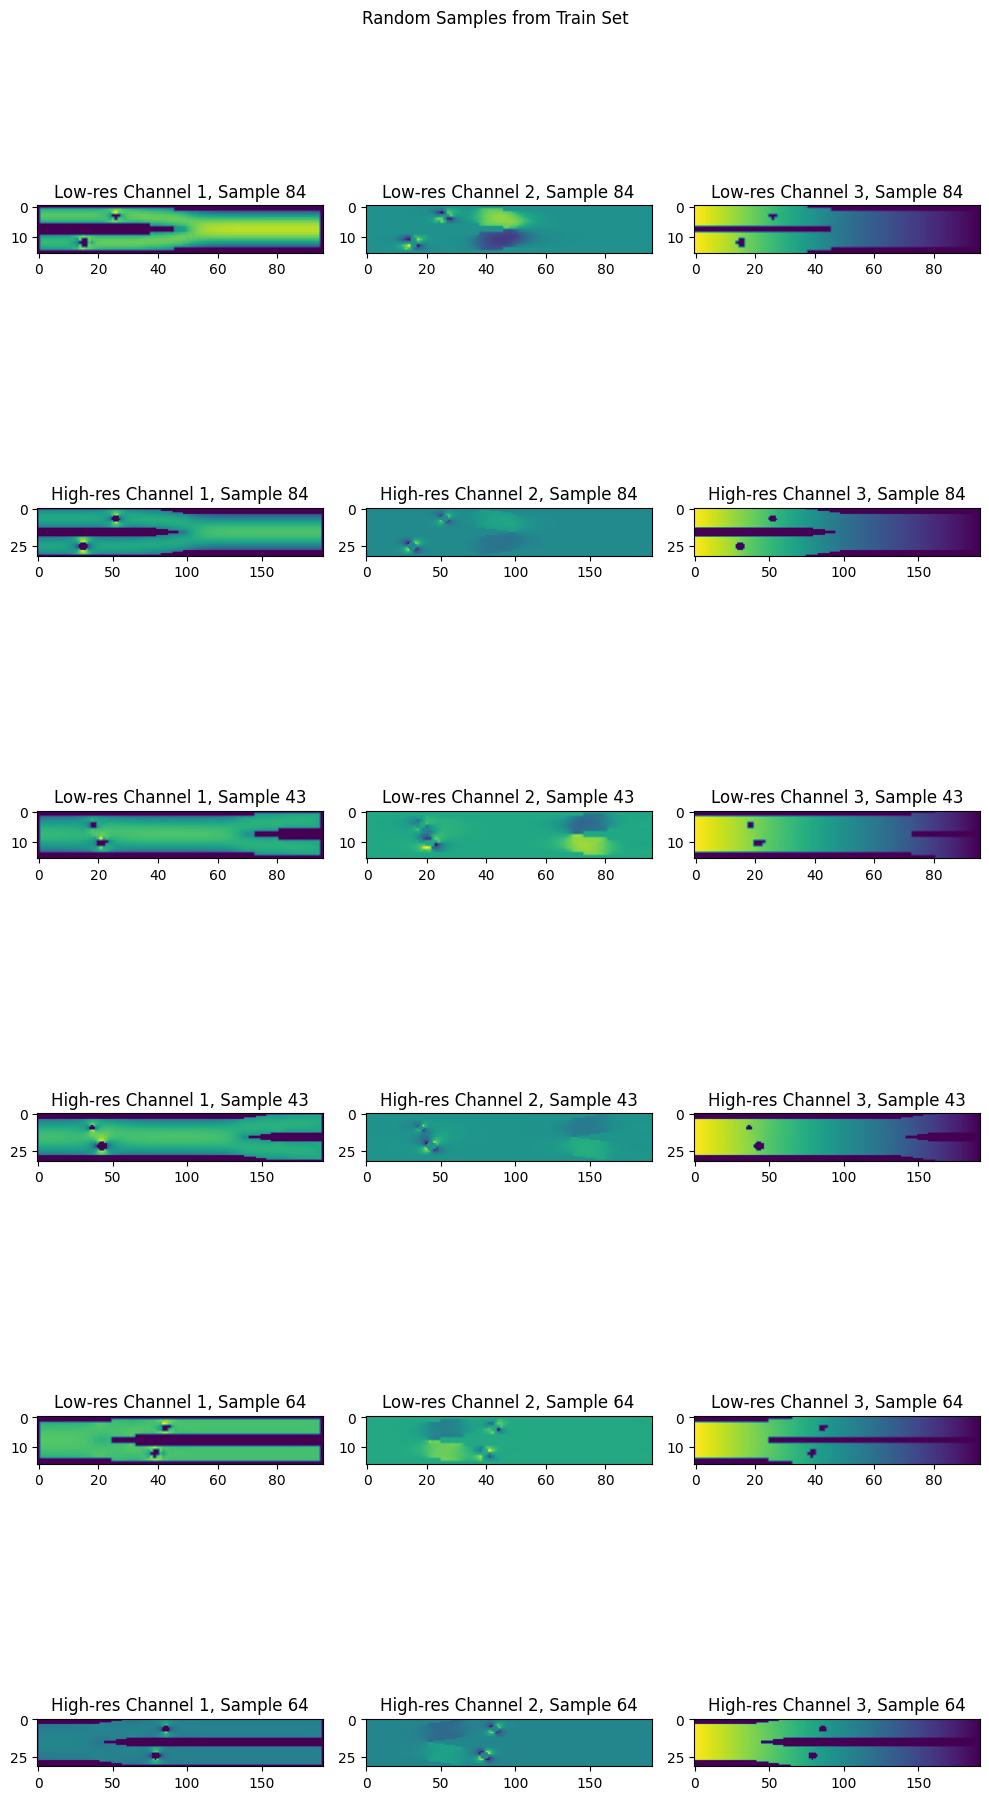

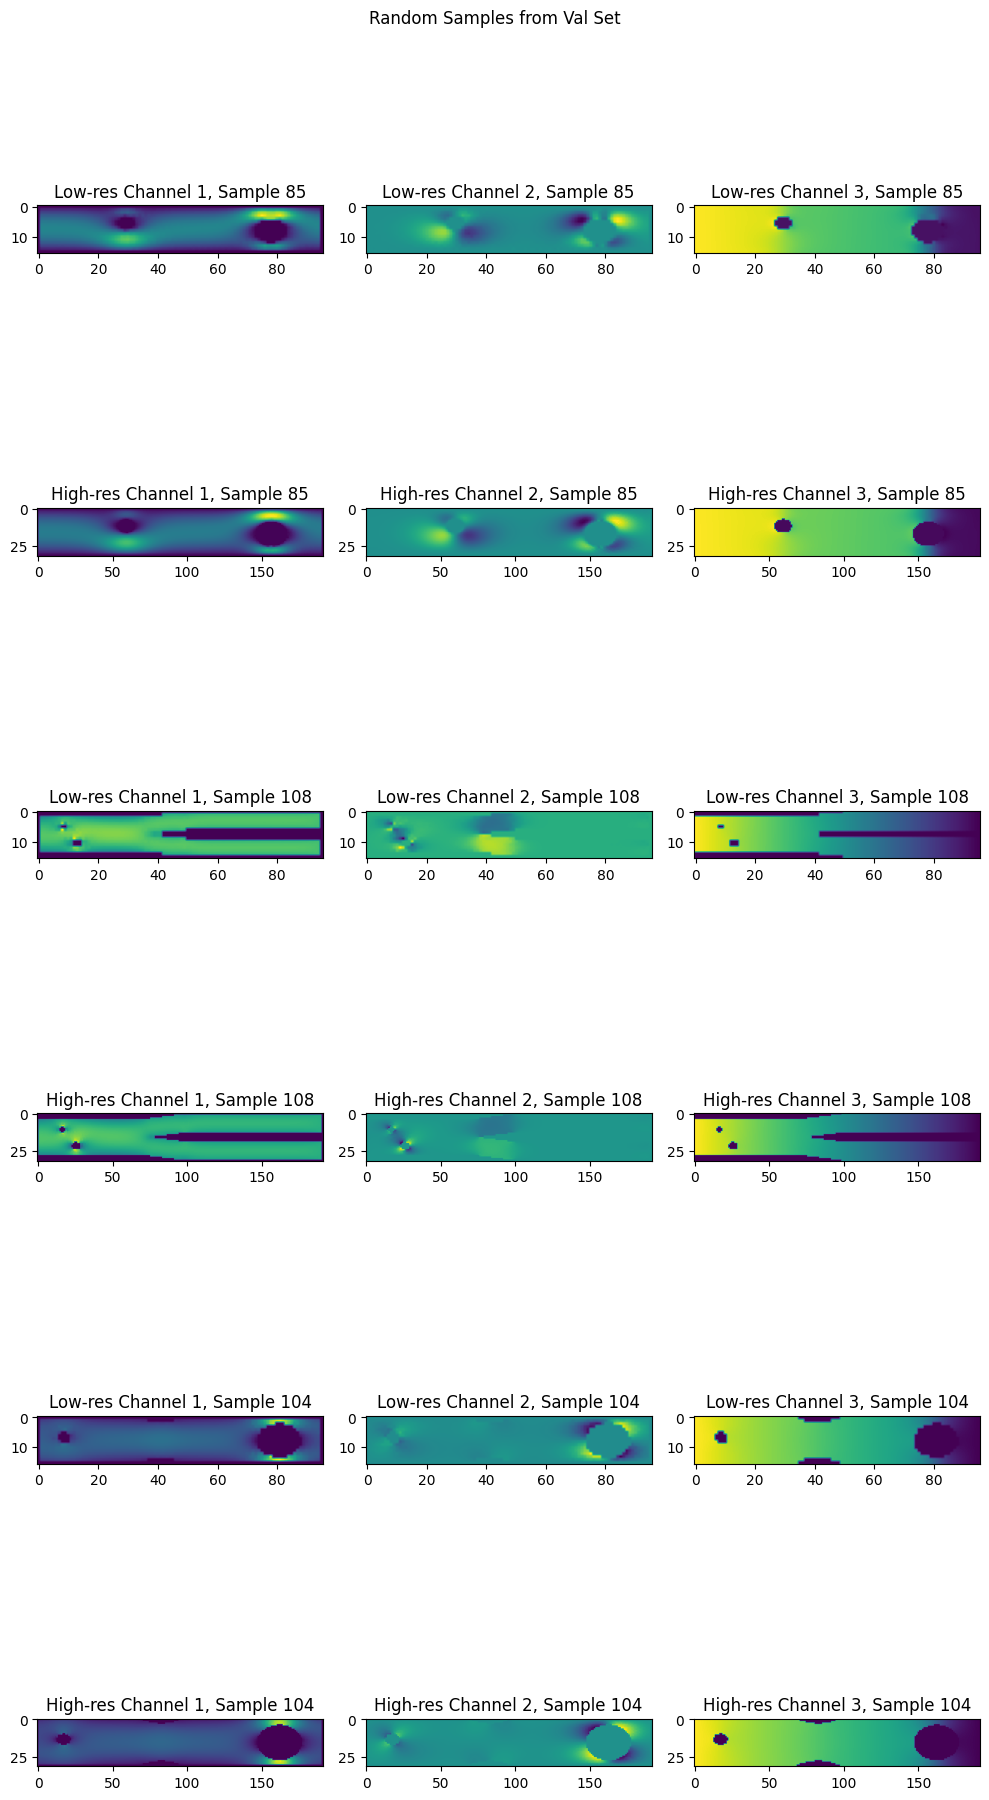

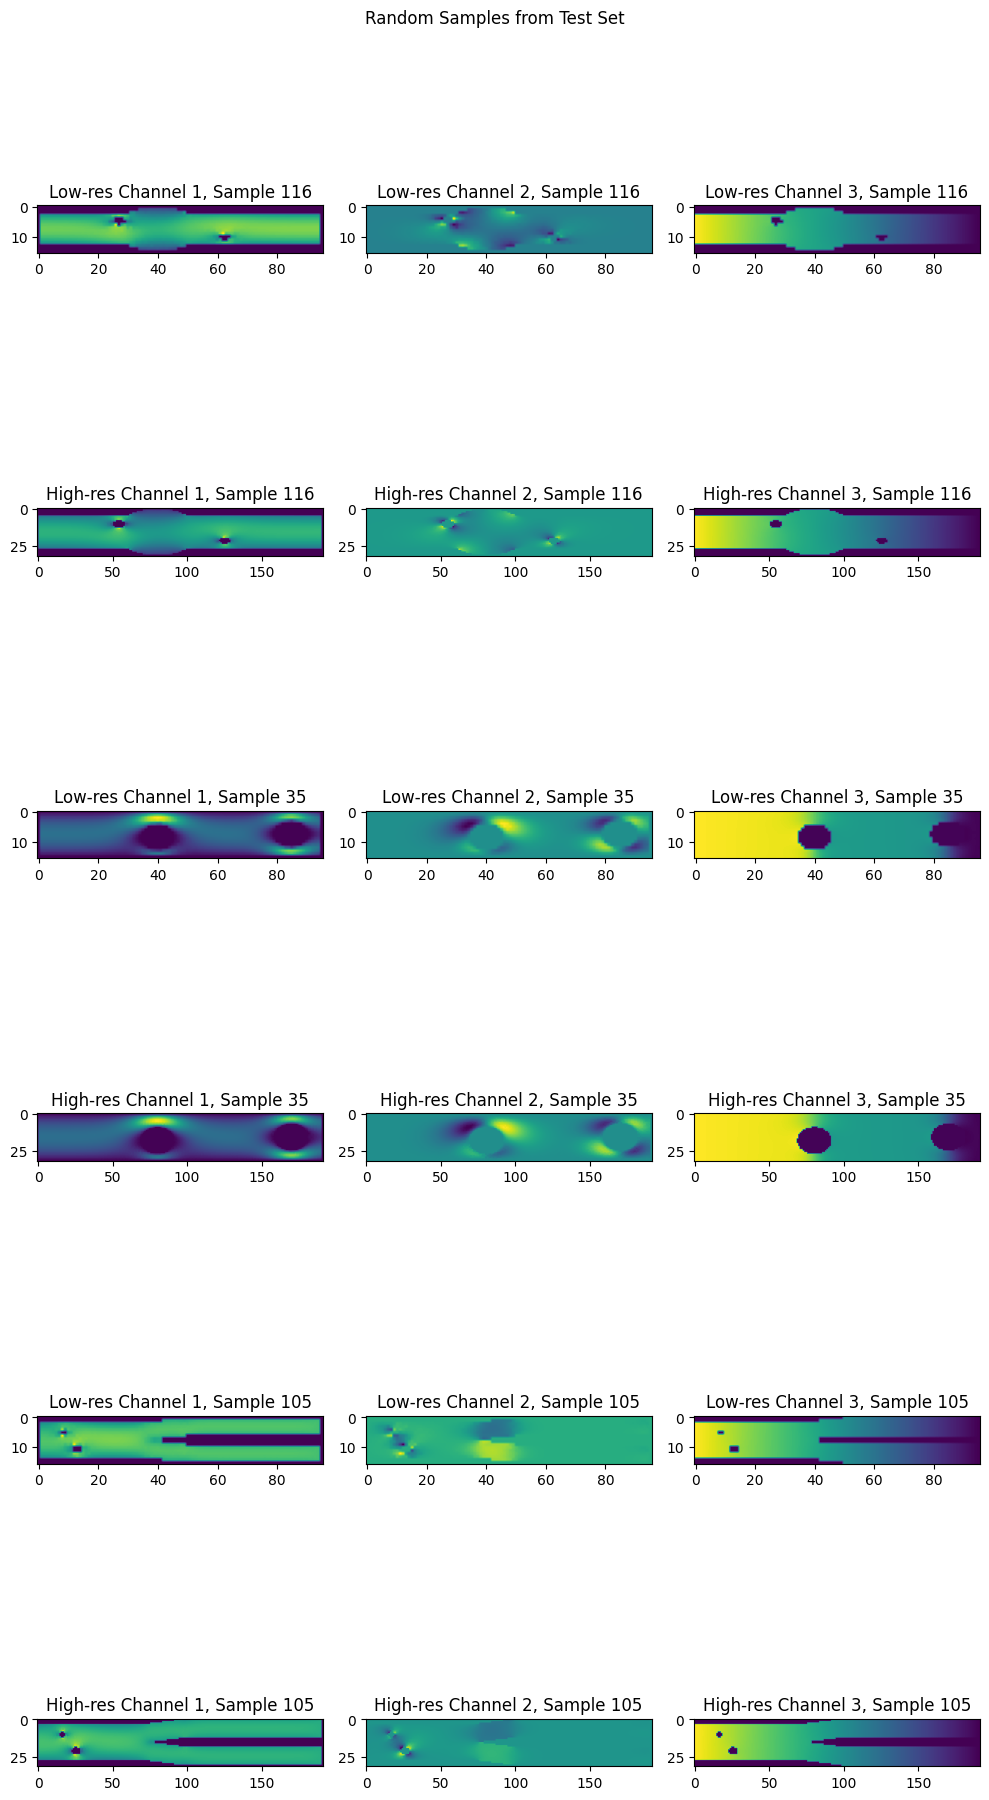

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the loaders to display images from
loaders = [train_loader, val_loader, test_loader]

# Loop over the loaders to display images from each set
for loader_idx, loader in enumerate(loaders):
    # Get a batch of data from the loader
    dataiter = iter(loader)
    low_res, high_res = next(dataiter)

    # Generate random indices to select 3 samples
    idx = np.random.randint(0, low_res.shape[0], size=3)

    # Display the input and ground truth images
    fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(10, 20))
    for i in range(3):
        for j in range(3):
            # Display each channel separately for the low-resolution image
            axs[i*2, j].imshow(low_res[idx[i]].cpu().numpy()[:,:,j])
            axs[i*2, j].set_title(f"Low-res Channel {j+1}, Sample {idx[i]+1}")

            # Display each channel separately for the high-resolution image
            axs[i*2+1, j].imshow(high_res[idx[i]].cpu().numpy()[:,:,j])
            axs[i*2+1, j].set_title(f"High-res Channel {j+1}, Sample {idx[i]+1}")

    # Set the overall title for the plot
    fig.suptitle(f"Random Samples from {['Train', 'Val', 'Test'][loader_idx]} Set")

    # Show the plot
    plt.tight_layout()
    plt.show()


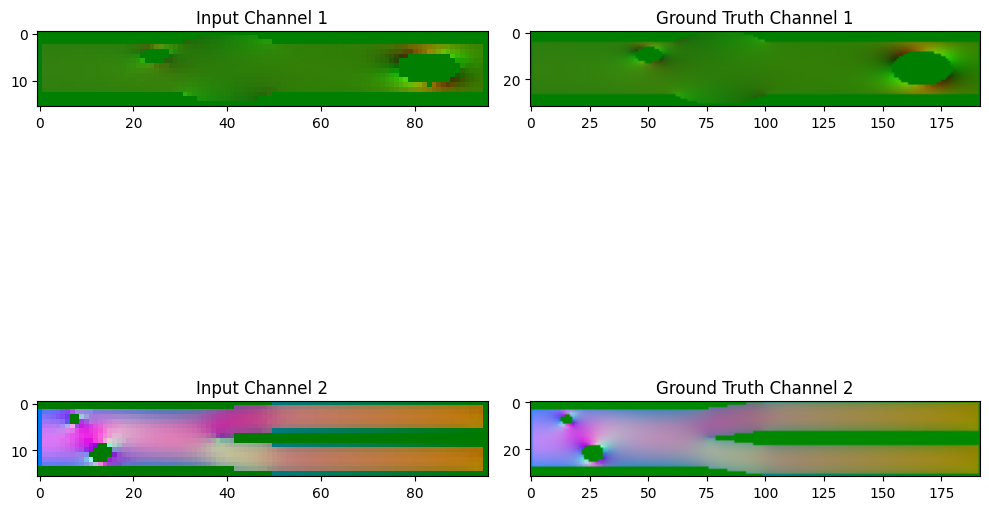

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of data from the test loader
dataiter = iter(test_loader)
low_res, high_res = next(dataiter)

# Display the input and ground truth images
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for i in range(2):
    # Display each channel separately for the low-resolution image
    axs[i, 0].imshow(low_res[i].cpu().numpy().squeeze(), cmap='gray')
    axs[i, 0].set_title('Input Channel ' + str(i+1))
    
    # Display each channel separately for the high-resolution image
    axs[i, 1].imshow(high_res[i].cpu().numpy().squeeze(), cmap='gray')
    axs[i, 1].set_title('Ground Truth Channel ' + str(i+1))

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Load the encoder and decoder checkpoint files
encoder_checkpoint = 'low.ckpt'
decoder_checkpoint = 'high.ckpt'

encoder = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(0.1),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(0.1),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(0.1),
        nn.BatchNorm2d(64))

decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.LeakyReLU(0.1),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.LeakyReLU(0.1),
        nn.BatchNorm2d(32),
        nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid())

encoder_state_dict = torch.load(encoder_checkpoint)['model_state_dict']
decoder_state_dict = torch.load(decoder_checkpoint)['model_state_dict']

# Freeze the encoder and decoder layers
for param in encoder.parameters():
    param.requires_grad = False

for param in decoder.parameters():
    param.requires_grad = False

# Create the DualAutoencoder instance
dual_autoencoder = DualAutoencoder(encoder, decoder).cuda()

print(dual_autoencoder)

DualAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.1)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.1)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (intermediate): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): BatchNorm2d(128, eps=1e

In [ ]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(dual_autoencoder.parameters(), lr=0.00005, weight_decay=0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dual_autoencoder.to(device)


# Define the number of epochs
num_epochs = 50

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)


In [ ]:
# Train the autoencoder
train_losses = []
val_losses = []
test_losses = []

for epoch in range(num_epochs):
  train_loss = 0.0
  val_loss = 0.0
  test_loss = 0.0

  # Update the learning rate
  scheduler.step()

  dual_autoencoder.train()
  for data in train_loader:
    low_res, high_res = data
    low_res = low_res.permute(0, 3, 1, 2).to(device)  # reshape images to [batch_size, num_channels, height, width]
    high_res = high_res.permute(0, 3, 1, 2).to(device)
    optimizer.zero_grad()
    outputs = dual_autoencoder(low_res)
    loss = criterion(outputs, high_res)
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * low_res.size(0)

  dual_autoencoder.eval()
  with torch.no_grad():
    valid_psnrs = []
    test_psnrs = []
    for data in val_loader:
      low_res, high_res = data
      low_res = low_res.permute(0, 3, 1, 2).to(device)  # reshape images to [batch_size, num_channels, height, width]
      high_res = high_res.permute(0, 3, 1, 2).to(device)
      outputs = dual_autoencoder(low_res)
      loss = criterion(outputs, high_res)
      val_loss += loss.item() * low_res.size(0)

      # Calculate PSNR
      psnr_value = psnr(high_res, outputs)
      valid_psnrs.append(psnr_value)

    for data in test_loader:
      low_res, high_res = data
      low_res = low_res.permute(0, 3, 1, 2).to(device)  # reshape images to [batch_size, num_channels, height, width]
      high_res = high_res.permute(0, 3, 1, 2).to(device)
      outputs = dual_autoencoder(low_res)
      loss = criterion(outputs, high_res)
      test_loss += loss.item() * low_res.size(0)

      # Calculate PSNR
      psnr_value = psnr(high_res, outputs)
      test_psnrs.append(psnr_value)

  train_loss = train_loss / len(train_loader.dataset)
  val_loss = val_loss / len(val_loader.dataset)
  test_loss = test_loss / len(test_loader.dataset)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  test_losses.append(test_loss)
  valid_psnr = np.mean(valid_psnrs)
  test_psnr = np.mean(test_psnrs)

  print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, Valid PSNR: {valid_psnr:.2f}, Test PSNR: {test_psnr:.2f}')


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/50, Training Loss: 0.0745, Validation Loss: 0.0492, Test Loss: 0.0492, Valid PSNR: 13.08, Test PSNR: 13.07
Epoch 2/50, Training Loss: 0.0430, Validation Loss: 0.0357, Test Loss: 0.0352, Valid PSNR: 14.47, Test PSNR: 14.54
Epoch 3/50, Training Loss: 0.0330, Validation Loss: 0.0291, Test Loss: 0.0285, Valid PSNR: 15.36, Test PSNR: 15.46
Epoch 4/50, Training Loss: 0.0277, Validation Loss: 0.0246, Test Loss: 0.0240, Valid PSNR: 16.10, Test PSNR: 16.22
Epoch 5/50, Training Loss: 0.0244, Validation Loss: 0.0224, Test Loss: 0.0218, Valid PSNR: 16.51, Test PSNR: 16.63
Epoch 6/50, Training Loss: 0.0218, Validation Loss: 0.0199, Test Loss: 0.0193, Valid PSNR: 17.02, Test PSNR: 17.15
Epoch 7/50, Training Loss: 0.0200, Validation Loss: 0.0184, Test Loss: 0.0180, Valid PSNR: 17.34, Test PSNR: 17.46
Epoch 8/50, Training Loss: 0.0189, Validation Loss: 0.0184, Test Loss: 0.0179, Valid PSNR: 17.36, Test PSNR: 17.48
Epoch 9/50, Training Loss: 0.0180, Validation Loss: 0.0174, Test Loss: 0.0169, V

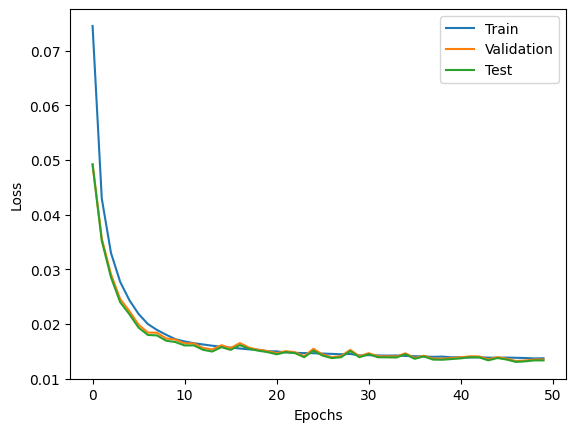

In [ ]:
# Plot the losses
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.plot(test_losses, label='Test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Saving the dual_autoencoder

PATH = './dual_autoencoder.ckpt'
torch.save({
        'epoch': num_epochs,
        'model_state_dict': dual_autoencoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, PATH)

(3, 32, 192, 3) (3, 16, 96, 3) (3, 32, 192, 3)


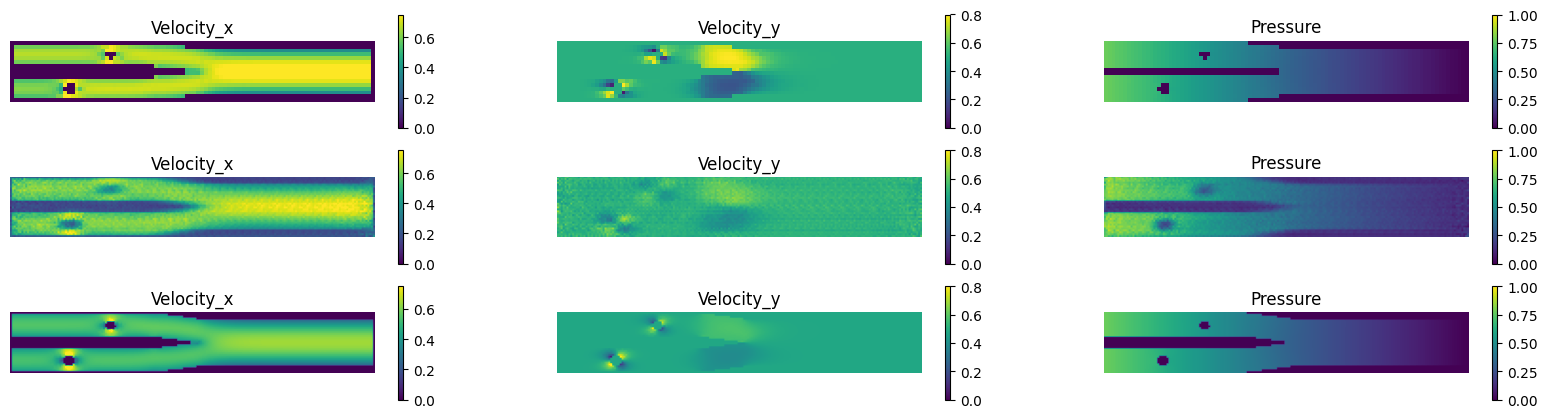

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Select 5 random images from the test set
test_images, high_image = next(iter(test_loader))
indices = torch.randperm(test_images.size(0))[:3]
images = test_images[indices].to(device)
high_img = high_image[indices].to(device)
images = images.permute(0, 3, 1, 2)

high_single_channel_images = high_img.permute(0, 3, 1, 2)


# Generate reconstructions
reconstructions = dual_autoencoder(images).detach().cpu().numpy()


single_channel_reconstructions = reconstructions.transpose(0, 2, 3, 1)
single_channel_images = images.cpu().numpy().transpose(0, 2, 3, 1)
high_single_channel_images = high_single_channel_images.cpu().numpy().transpose(0, 2, 3, 1)

print(single_channel_reconstructions.shape, single_channel_images.shape, high_single_channel_images.shape)

# Visualize the images and their reconstructions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 5))
for i in range(1):
      for j in range(3):
        if j == 0:
            im = axes[i,j].imshow(single_channel_images[i,:,:,j], vmin=0, vmax=0.75)
        elif j == 1:
            im = axes[i,j].imshow(single_channel_images[i,:,:,j], vmin=0, vmax=0.8)
        elif j == 2:
            im = axes[i,j].imshow(single_channel_images[i,:,:,j], vmin=0, vmax=1.0)
        axes[i,j].axis('off')
        axes[i,0].set_title('Velocity_x')
        axes[i,1].set_title('Velocity_y')
        axes[i,2].set_title('Pressure')
        fig.colorbar(im, ax=axes[i,j])

for i in range(1):
      for j in range(3):
        if j == 0:
            im2 = axes[i+1,j].imshow(single_channel_reconstructions[i,:,:,j], vmin=0, vmax=0.75)
        elif j == 1:
            im2 = axes[i+1,j].imshow(single_channel_reconstructions[i,:,:,j], vmin=0, vmax=0.8)
        elif j == 2:
            im2 = axes[i+1,j].imshow(single_channel_reconstructions[i,:,:,j], vmin=0, vmax=1.0)
        axes[i+1,j].axis('off')
        axes[i+1,0].set_title('Velocity_x')
        axes[i+1,1].set_title('Velocity_y')
        axes[i+1,2].set_title('Pressure')
        fig.colorbar(im2, ax=axes[i+1,j])

for i in range(1):
      for j in range(3):
        if j == 0:
            im3 = axes[i+2,j].imshow(high_single_channel_images[i,:,:,j], vmin=0, vmax=0.75)
        elif j == 1:
            im3 = axes[i+2,j].imshow(high_single_channel_images[i,:,:,j], vmin=0, vmax=0.8)
        elif j == 2:
            im3 = axes[i+2,j].imshow(high_single_channel_images[i,:,:,j], vmin=0, vmax=1.0)
        axes[i+2,j].axis('off')
        axes[i+2,0].set_title('Velocity_x')
        axes[i+2,1].set_title('Velocity_y')
        axes[i+2,2].set_title('Pressure')
        fig.colorbar(im3, ax=axes[i+2,j])

plt.show()
